# 2018-04-27 - Limite de reconnaissance de l'orientation des MC
On se rapproche ici plus des phénomènes de discrimination observables en psychophysique : le but est de voir si il existe une limite à la capacité de reconnaissance des orientations des MotionClouds.

On génère un set de N_theta MotionClouds, lesquels sont répartis successivement dans des "chunks", qui représente des ranges de valeurs de B$\theta$. Ici, B$\theta$ varie de 1 à 180°.

In [13]:
import numpy as np
import MotionClouds as mc
import matplotlib.pyplot as plt
import os
import imageio


downscale = 1
fx, fy, ft = mc.get_grids(mc.N_X/downscale, mc.N_Y/downscale, 1)

N_theta = 1000
nbr_chunks = 50 

bw_values = np.pi*np.logspace(-7,0, N_theta, base=2)
bw_subsets = np.array_split(bw_values, nbr_chunks)

fig_width = 21
print('Btheta list : \n'+str( bw_values*180/np.pi))

theta_list = [0,np.pi/2, np.pi/4, 3*np.pi/4] #liste des angles theta

Btheta list : 
[  1.40625      1.41309661   1.41997656   1.42689      1.4338371
   1.44081802   1.44783293   1.454882     1.46196538   1.46908326
   1.47623578   1.48342313   1.49064548   1.49790298   1.50519583
   1.51252417   1.5198882    1.52728808   1.53472399   1.54219611
   1.5497046    1.55724964   1.56483143   1.57245012   1.58010591
   1.58779898   1.59552949   1.60329765   1.61110363   1.61894761
   1.62682978   1.63475033   1.64270944   1.6507073    1.6587441
   1.66682003   1.67493528   1.68309004   1.6912845    1.69951886
   1.70779331   1.71610804   1.72446326   1.73285915   1.74129593
   1.74977378   1.7582929    1.7668535    1.77545578   1.78409995
   1.7927862    1.80151474   1.81028577   1.81909951   1.82795617
   1.83685594   1.84579904   1.85478568   1.86381608   1.87289044
   1.88200899   1.89117193   1.90037948   1.90963186   1.91892928
   1.92827197   1.93766015   1.94709404   1.95657386   1.96609983
   1.97567219   1.98529114   1.99495693   2.00466978   2.014429

In [14]:
for chunk_index, chunk in enumerate(bw_subsets) : #split into ranges
    for t in theta_list :
        if not os.path.exists('./clouds_boundary/chunk%s/%s' % (chunk_index,t)): #si le folder n'existe pas on le crée
            os.makedirs('./clouds_boundary/chunk%s/%s' % (chunk_index,t))

        for i_ax, B_theta in enumerate(chunk):
            mc_i = mc.envelope_gabor(fx, fy, ft, V_X=0., V_Y=0., B_V=0, theta=t, B_theta=B_theta)
            im = mc.random_cloud(mc_i)

            imageio.imwrite('./clouds_boundary/chunk%s/%s/B0 %s.png' % (chunk_index , t, (B_theta*180/np.pi) ) , im[:, :, 0])

            #plt.imshow(im[:, :, 0], cmap=plt.gray())
            #plt.text(5, 29, r'$B_\theta=%.1f$°' % (B_theta*180/np.pi), color='yellow', fontsize=32)
            #plt.show()  

On recharge le modèle :

In [15]:
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(32 * 32, 200)
            self.fc2 = nn.Linear(200, 200)
            self.fc3 = nn.Linear(200, 4)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return F.log_softmax(input=x)
model = Net()
print(model)
model.load_state_dict(torch.load("MODEL_trainEASY_pytorchMCV2"))

Net(
  (fc1): Linear(in_features=1024, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=4, bias=True)
)


On défini le critère d'optimisation SGD :

In [16]:
import torch.optim as optim

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

On importe les données de chaque chunk et on teste :

In [17]:
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((32,32)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

ez_range_list = []
ez_acc_list = []

for chunk_index, chunk in enumerate(bw_subsets):
    test_loss = 0
    correct = 0
    data_set = datasets.ImageFolder(root='clouds_boundary/chunk%s'%chunk_index,
                                transform=data_transform)
    data_loader = torch.utils.data.DataLoader(data_set,
                                             batch_size=4,shuffle=False,
                                             num_workers=1)

    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)

        #rescale
        data = data.view(-1, 32 * 32)
        net_out = model(data)

        #somme des pertes du batch
        test_loss += criterion(net_out, target).data[0]
        pred = net_out.data.max(1)[1] #index of max_log probability
        correct += pred.eq(target.data).sum() #sum up pred equals target in the batch

    test_loss /= len(data_loader.dataset) #loss = loss/length set
    print("Chunk index : %s" % chunk_index)
    print("Chunk range : %s : %s" % (chunk[1]*180/np.pi, chunk[-1]*180/np.pi))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    
    ez_range_list.append( ( chunk[1]*180/np.pi + chunk[-1]*180/np.pi ) / 2 )
    ez_acc_list.append(100 * correct /len(data_loader.dataset))


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Chunk index : 0
Chunk range : 1.4130966107050533 : 1.5421961050619397

Test set: Average loss: 0.0001, Accuracy: 80/80 (100%)

Chunk index : 1
Chunk range : 1.5572496449329627 : 1.6995188572609006

Test set: Average loss: 0.0000, Accuracy: 80/80 (100%)

Chunk index : 2
Chunk range : 1.7161080412144585 : 1.8728904428593347

Test set: Average loss: 0.0033, Accuracy: 79/80 (99%)

Chunk index : 3
Chunk range : 1.8911719252616708 : 2.0639480379801105

Test set: Average loss: 0.0009, Accuracy: 80/80 (100%)

Chunk index : 4
Chunk range : 2.084094453847375 : 2.274495830614846

Test set: Average loss: 0.0001, Accuracy: 80/80 (100%)

Chunk index : 5
Chunk range : 2.2966974258336714 : 2.50652205786499

Test set: Average loss: 0.0000, Accuracy: 80/80 (100%)

Chunk index : 6
Chunk range : 2.5309884857153913 : 2.762217781188637

Test set: Average loss: 0.0001, Accuracy: 80/80 (100%)

Chunk index : 7
Chunk range : 2.7891800821340804 : 3.043997576950766

Test set: Average loss: 0.0011, Accuracy: 80/80

Et on plot :

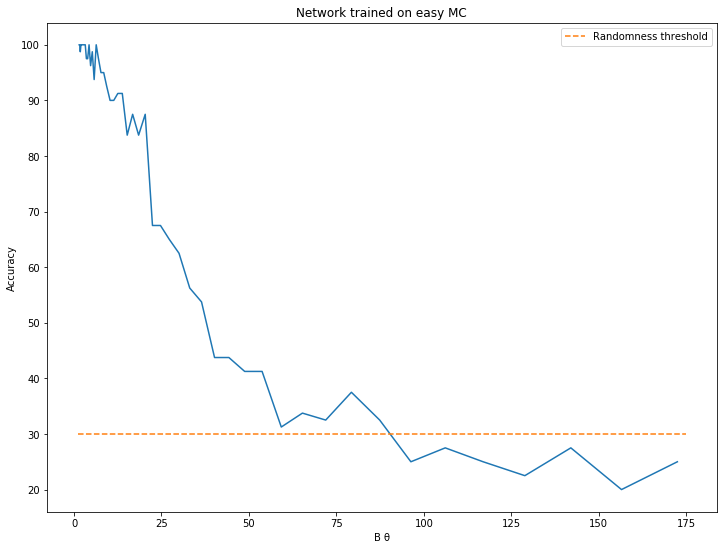

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 9]
plt.ylabel("Accuracy")
plt.xlabel("B θ")
plt.title("Network trained on easy MC")

plt.plot(ez_range_list, ez_acc_list)
plt.plot([1,175],[30,30],'--', label = 'Randomness threshold')
plt.legend()
plt.show()

On peut maintenant faire le même test avec les réseaux entrainés sur les sets medium et sur les set hards :

Net(
  (fc1): Linear(in_features=1024, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=4, bias=True)
)


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


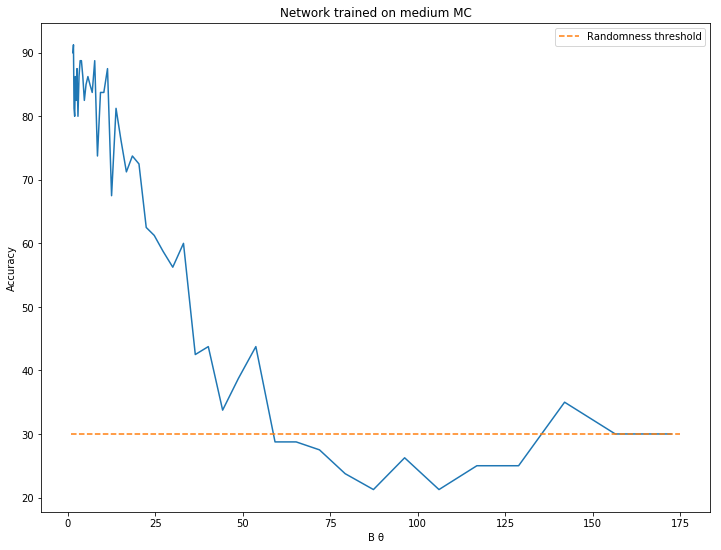

In [20]:
#MODEL LOADING
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(32 * 32, 200)
            self.fc2 = nn.Linear(200, 200)
            self.fc3 = nn.Linear(200, 4)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return F.log_softmax(input=x)
model = Net()
model.load_state_dict(torch.load("MODEL_trainMEDIUM_pytorchMCV2"))

#LOOP
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((32,32)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

med_range_list = []
med_acc_list = []

print("Testing")
for chunk_index, chunk in enumerate(bw_subsets):
    test_loss = 0
    correct = 0
    data_set = datasets.ImageFolder(root='clouds_boundary/chunk%s'%chunk_index,
                                transform=data_transform)
    data_loader = torch.utils.data.DataLoader(data_set,
                                             batch_size=4,shuffle=False,
                                             num_workers=1)

    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)

        #rescale
        data = data.view(-1, 32 * 32)
        net_out = model(data)

        #somme des pertes du batch
        test_loss += criterion(net_out, target).data[0]
        pred = net_out.data.max(1)[1] #index of max_log probability
        correct += pred.eq(target.data).sum() #sum up pred equals target in the batch

    test_loss /= len(data_loader.dataset) #loss = loss/length set

    
    med_range_list.append( ( chunk[1]*180/np.pi + chunk[-1]*180/np.pi ) / 2 )
    med_acc_list.append(100 * correct /len(data_loader.dataset))

#PLOT
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 9]
plt.ylabel("Accuracy")
plt.xlabel("B θ")
plt.title("Network trained on medium MC")

plt.plot(med_range_list, med_acc_list)
plt.plot([1,175],[30,30],'--', label = 'Randomness threshold')
plt.legend()
plt.show()


Net(
  (fc1): Linear(in_features=1024, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=4, bias=True)
)


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


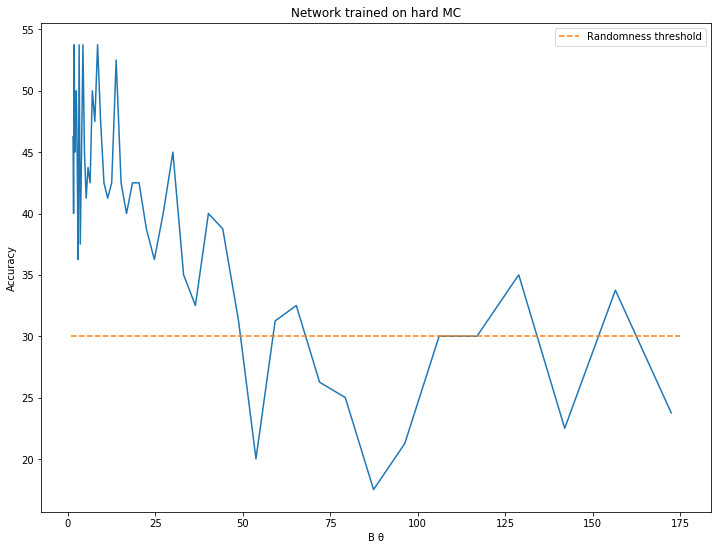

In [21]:
#MODEL LOADING
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(32 * 32, 200)
            self.fc2 = nn.Linear(200, 200)
            self.fc3 = nn.Linear(200, 4)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return F.log_softmax(input=x)
model = Net()
print(model)
model.load_state_dict(torch.load("MODEL_trainHARD_pytorchMCV2"))

#LOOP
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((32,32)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

hard_range_list = []
hard_acc_list = []

for chunk_index, chunk in enumerate(bw_subsets):
    test_loss = 0
    correct = 0
    data_set = datasets.ImageFolder(root='clouds_boundary/chunk%s'%chunk_index,
                                transform=data_transform)
    data_loader = torch.utils.data.DataLoader(data_set,
                                             batch_size=4,shuffle=False,
                                             num_workers=1)

    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)

        #rescale
        data = data.view(-1, 32 * 32)
        net_out = model(data)

        #somme des pertes du batch
        test_loss += criterion(net_out, target).data[0]
        pred = net_out.data.max(1)[1] #index of max_log probability
        correct += pred.eq(target.data).sum() #sum up pred equals target in the batch

    test_loss /= len(data_loader.dataset) #loss = loss/length set

    
    hard_range_list.append( ( chunk[1]*180/np.pi + chunk[-1]*180/np.pi ) / 2 )
    hard_acc_list.append(100 * correct /len(data_loader.dataset))

#PLOT
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 9]
plt.ylabel("Accuracy")
plt.xlabel("B θ")
plt.title("Network trained on hard MC")

plt.plot(hard_range_list, hard_acc_list)
plt.plot([1,175],[30,30],'--', label = 'Randomness threshold')
plt.legend()
plt.show()


Donc on a une précision de prédiction supérieure à un random guess pour Bθ = 75° avec l'entrainement facile, Bθ = 70° avec l'entrainement moyen et Bθ = 40° avec l'entrainement difficile.

Moins l'environnement de l'entrainement est bruité, meilleur sera la distinction des angles même dans les situations les plus ambigües. Autrement dit, s'entrainer sur des cas difficiles n'augmente pas la performance en dans les situations de détection d'dangles difficiles.

On peut tout plotter maintenant :

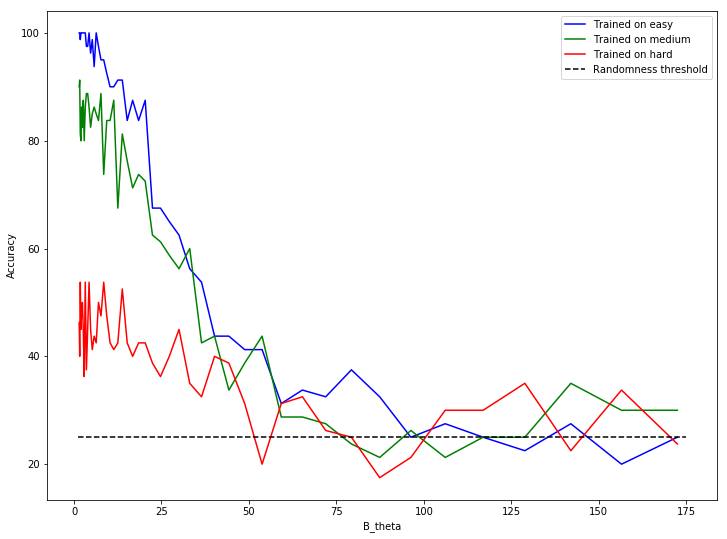

In [30]:
plt.plot(ez_range_list, ez_acc_list, color = 'blue', label = 'Trained on easy')
plt.plot(med_range_list, med_acc_list, color = 'green', label = 'Trained on medium')
plt.plot(hard_range_list, hard_acc_list, color = 'red', label = 'Trained on hard')
plt.plot([1,175],[25,25],'--', color = 'black',label = 'Randomness threshold')

plt.xlabel("B_theta")
plt.ylabel("Accuracy")
plt.legend()
plt.show()